<a href="https://colab.research.google.com/github/KenzaB27/BGNHackathon2021/blob/machine_learning/machine_learning/alphnum_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BGN Hackathon - MNIST Language Classifier using CNNs
[Kaggle notebook](https://www.kaggle.com/taha07/mnist-sign-language-classification-98)

# Environnement Setup

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten,Dense,Dropout,MaxPool2D,Conv2D

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!echo '{"username":"kenzabouzid","key":"7fa6e6d68e8f429177c6eb453105e3c1"}' > /root/.kaggle/kaggle.json
!chmod 600  /root/.kaggle/kaggle.json
!kaggle datasets download -d datamunge/sign-language-mnist
!unzip /content/sign-language-mnist.zip -d sign-language-mnist

 91% 57.0M/62.6M [00:03<00:00, 8.99MB/s]
100% 62.6M/62.6M [00:03<00:00, 19.8MB/s]
Archive:  /content/sign-language-mnist.zip
  inflating: sign-language-mnist/amer_sign2.png  
  inflating: sign-language-mnist/amer_sign3.png  
  inflating: sign-language-mnist/american_sign_language.PNG  
  inflating: sign-language-mnist/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_test/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_train.csv  
  inflating: sign-language-mnist/sign_mnist_train/sign_mnist_train.csv  


# Loading  +  Preprocessing

In [ ]:
df_train = pd.read_csv("/content/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [ ]:
df_test = pd.read_csv("/content/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [ ]:
df_train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,165.533673,166.685522,167.811983,168.495647,169.310872,169.956948,170.460463,170.716518,170.872701,170.808887,170.481442,169.979749,169.264506,168.144127,166.936660,165.765944,163.620725,161.933600,161.349117,147.146858,150.284502,152.941978,155.415043,158.068986,160.229576,162.345802,164.291167,165.736332,166.991732,168.503187,...,131.949918,134.583755,139.361974,148.115862,155.095465,160.346858,163.915607,165.364414,165.911273,165.182080,164.407977,163.488254,143.407758,144.189474,145.711637,147.660718,149.019414,148.670843,148.185212,147.298926,146.286323,144.027062,142.966017,139.769550,137.071572,135.277181,131.922783,130.232235,132.046367,135.289237,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,31.279244,30.558445,29.771007,29.329251,28.620248,27.961255,27.053544,26.763535,26.307419,26.088459,26.475963,26.940885,27.871515,29.368386,30.906718,31.902723,34.303747,35.991306,36.571064,41.555429,40.094304,39.427215,38.686176,37.242459,36.373576,35.242915,33.899171,32.759395,31.656140,30.833853,...,57.586028,60.373218,63.301768,63.300608,63.511566,62.551522,61.833119,62.210750,62.163516,61.958245,61.950177,62.403709,54.406116,53.658786,54.710497,54.613724,54.351761,55.233710,55.904715,57.155523,57.965677,57.393379,56.689603,56.118823,54.680900,55.278778,56.384076,58.111783,59.204300,62.553694,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,23.000000,28.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [ ]:
train_label = df_train["label"]
test_label = df_test["label"]

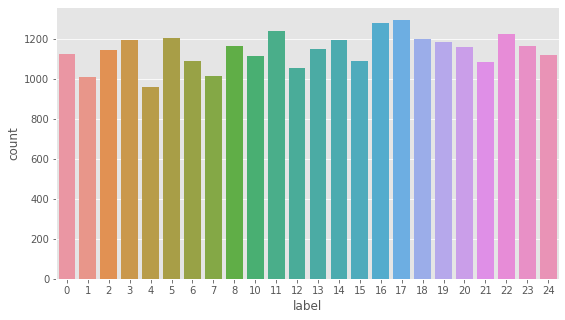

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize =(9,5))
sns.countplot(x= df_train['label'],data = df_train)
plt.show()

In [ ]:
df_train.drop("label",axis=1,inplace=True)
df_train.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,163,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,159,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149


In [ ]:
df_test.drop("label",axis=1,inplace=True)
df_test.head(2)

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,153,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180


In [ ]:
x_train = df_train.values
x_train

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]])

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_test = df_test.values.reshape(-1,28,28,1)

### One Hot Encoding
* Converting Integer labels into binary From unsing Label Binarizer

In [ ]:
lb = LabelBinarizer()
y_train = lb.fit_transform(train_label)
y_test = lb.fit_transform(test_label)

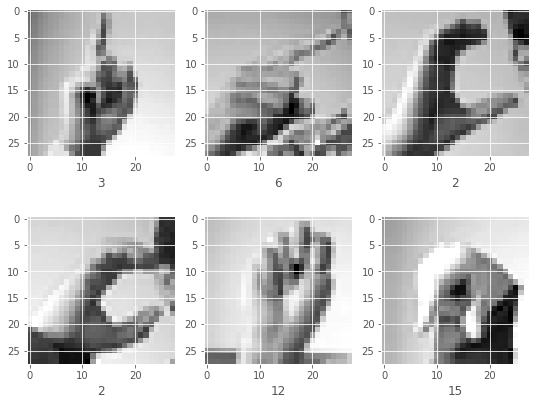

In [ ]:
plt.figure(figsize=(9,7))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_train[i][:,:,0],cmap='gray')
    plt.xlabel(np.argmax(y_train[i]))
    
plt.show()

### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=(1./255),rotation_range = 30,
                                  width_shift_range = 0.2,height_shift_range =0.2,
                                  shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=(1./255))

train_datagen_flow = train_datagen.flow(x_train, y_train, batch_size=32)
val_datagen_flow = val_datagen.flow(x_test,y_test)

In [ ]:
train_datagen_flow

 # Model Building

In [ ]:
from tensorflow.keras import Sequential

model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',input_shape=(28,28,1),activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(24,activation="softmax"))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

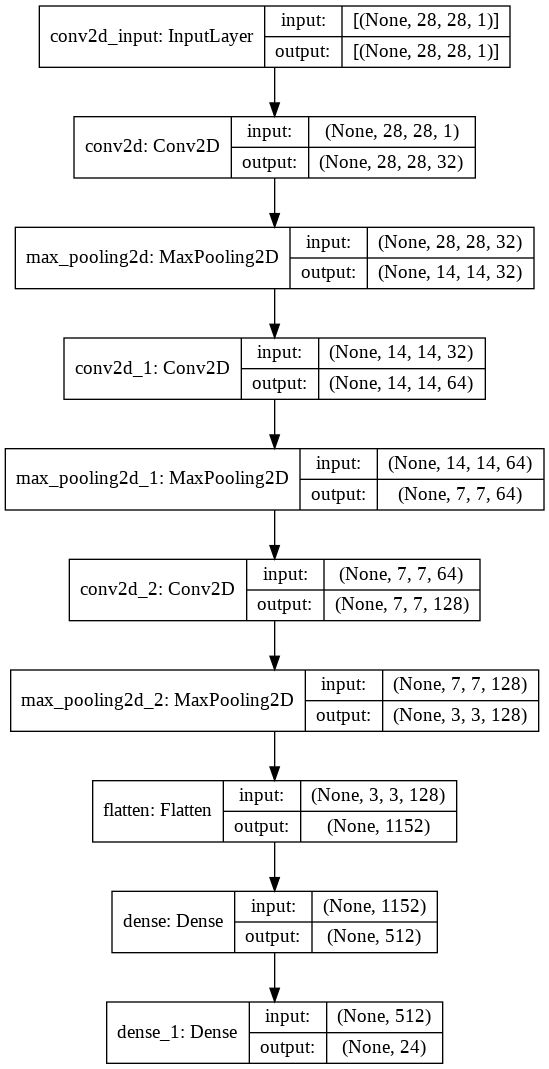

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/sign_lan.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)
with tf.device('/device:GPU:0'):
  history = model.fit(train_datagen_flow, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_data=val_datagen_flow)


Epoch 1/20
858/858 [==============================] - 10s 12ms/step - loss: 0.0736 - accuracy: 0.9763 - val_loss: 0.0379 - val_accuracy: 0.9881

Epoch 00001: val_accuracy improved from -inf to 0.98815, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/sign_lan.h5
Epoch 2/20
858/858 [==============================] - 11s 12ms/step - loss: 0.0695 - accuracy: 0.9781 - val_loss: 0.0186 - val_accuracy: 0.9927

Epoch 00002: val_accuracy improved from 0.98815 to 0.99275, saving model to /content/gdrive/MyDrive/BGNHackathon/alphabet_model/sign_lan.h5
Epoch 3/20
858/858 [==============================] - 10s 12ms/step - loss: 0.0745 - accuracy: 0.9754 - val_loss: 0.0292 - val_accuracy: 0.9895

Epoch 00003: val_accuracy did not improve from 0.99275
Epoch 4/20
858/858 [==============================] - 10s 12ms/step - loss: 0.0706 - accuracy: 0.9771 - val_loss: 0.0207 - val_accuracy: 0.9912

Epoch 00004: val_accuracy did not improve from 0.99275
Epoch 5/20
858/858 [=============

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/BGNHackathon/alphabet_model/sign_lan.h5'
model.load_weights(checkpoint_filepath)
model.save_weights(checkpoint_filepath)

# Model Evaluation

In [ ]:
import warnings
warnings.filterwarnings("ignore")
loss,acc = model.evaluate_generator(val_datagen.flow(x_test,y_test))
print(f"Accuracy: {acc*100}")
print(f"Loss: {loss}")

Accuracy: 99.9721109867096
Loss: 0.0026627222541719675


In [ ]:
x_test = x_test/255.
y_pred = model.predict_classes(x_test)

In [ ]:
y_te = np.argmax(y_test,axis=1)
y_te

array([6, 5, 9, ..., 2, 4, 2])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_te,y_pred)

0.9997211377579476

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_te,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
           9       1.00      1.00      1.00       331
          10       1.00      1.00      1.00       209
          11       1.00      1.00      1.00       394
          12       1.00      1.00      1.00       291
          13       1.00      1.00      1.00       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       1.00      0.99      0.99       144
          17       1.00    

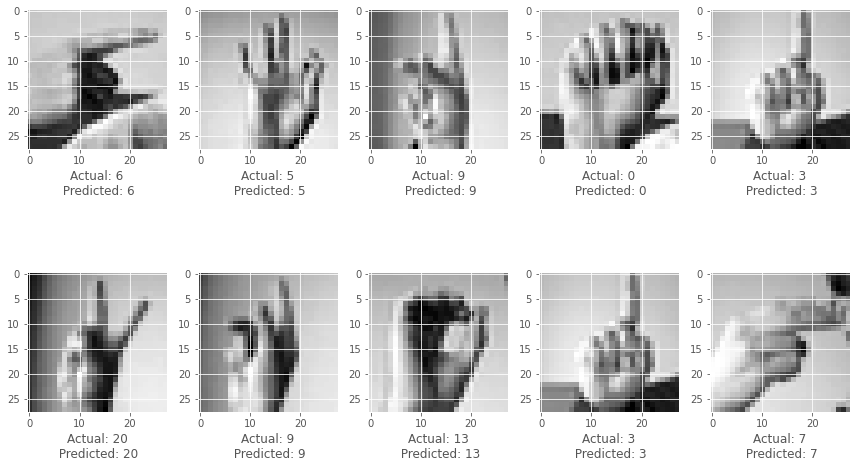

In [ ]:
plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i][:,:,0], cmap='gray')
    plt.xlabel(f"Actual: {y_te[i]}\n Predicted: {y_pred[i]}")
    
plt.tight_layout()
plt.show()

## Test on new data 
[ASL alphabet](https://www.kaggle.com/kuzivakwashe/significant-asl-sign-language-alphabet-dataset)

In [ ]:
import cv2
def test_model(path, model):
  im = cv2.imread(path, 0)
  im = cv2.resize(im, (28,28))
  im = im/255.
  im = im.reshape(1,28,28,1)

  plt.imshow(im[0,:,:,0], cmap="gray")

  res = model.predict_classes(im)
  return res

array([2])

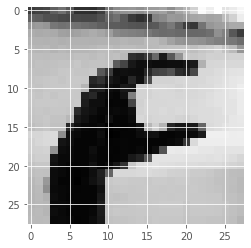

In [ ]:
path = "/content/gdrive/MyDrive/BGNHackathon/alphabet_model/test/C.jpg"
test_model(path, model)

array([14])

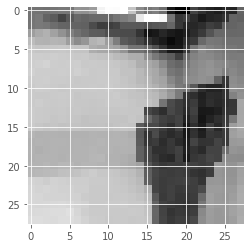

In [ ]:
test_model("/content/gdrive/MyDrive/BGNHackathon/alphabet_model/test/A.jpg", model)

## Save in tflite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(f'{checkpoint_filepath[:-2]}tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp38ag8s_w/assets


INFO:tensorflow:Assets written to: /tmp/tmp38ag8s_w/assets


2785124